2019-04-07

# Get US Stock Price

In [1]:
from FinMind.Data import Load
import datetime

In [2]:
#date = str( datetime.datetime.now().date())
date = str( datetime.datetime.now().date() - datetime.timedelta(30) )
date2 = str( datetime.datetime.now().date() - datetime.timedelta(200) )
date3 = str( datetime.datetime.now().date() - datetime.timedelta(400) )
today = str( datetime.datetime.now().date() )

In [3]:
stock_id = 'NVDA'
date_from = '2010-01-01'

print('load USStockPrice {} '.format(stock_id))
USStockPrice = Load.FinData(
        dataset = 'USStockPrice',
        select = stock_id,
        date = date_from)
print( USStockPrice[:5] )

load USStockPrice NVDA 
    Open   High    Low  Close  Adj_Close    Volume        date stock_id
0  18.51  18.62  18.11  18.49    17.0957  20005100  2010-01-04     NVDA
1  18.42  18.96  18.42  18.76    17.3453  18216200  2010-01-05     NVDA
2  18.75  18.92  18.57  18.88    17.4563  16229200  2010-01-06     NVDA
3  18.78  18.86  18.37  18.51    17.1142  13694800  2010-01-07     NVDA
4  18.36  18.68  18.25  18.55    17.1511  11954200  2010-01-08     NVDA


## 預測 明天 股價
### GRU & LSTM model 

In [4]:
from FinMind.Data import Load
import numpy as np 
import pandas as pd
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM , GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from keras.optimizers import Adam 

Using TensorFlow backend.


In [5]:
USStockInfo = Load.FinData(dataset = 'USStockInfo')
stock_id = 'NVDA'
date_from = '2010-01-01'

print('input data')
data = Load.FinData(
        dataset = 'USStockPrice',
        select = stock_id,
        date = date_from)

input data


In [6]:
#colname = ['date', 'open', 'high', 'low', 'close', 'volume']
#data = data[colname]
print('select close price')
date = [ str(d) for d in data['date'] ]
stock_price = data['Close'].values.astype('float32')
stock_price = stock_price.reshape(len(stock_price), 1)

select close price


 畫圖 


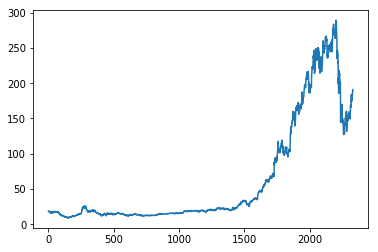

In [7]:
print(' 畫圖 ')
plt.plot(stock_price)
plt.show()

In [8]:
print(' 取 80% data 當作 training data, 20% data 當作 testing data 做模型驗證 ')
train_size = int(len(stock_price) * 0.8)
test_size = len(stock_price) - train_size
test_size = train_size + int(test_size/2)
valid_size = test_size

train = stock_price[:train_size,:]
test = stock_price[train_size:test_size,:]
valid = stock_price[valid_size:,:]

train_date = date[:train_size]
test_date = date[train_size:test_size]
valid_date = date[valid_size:]

 取 80% data 當作 training data, 20% data 當作 testing data 做模型驗證 


In [9]:
print(' 歸一化 ')
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

 歸一化 


In [10]:
print('切 data，拿前五天的股價，預測未來1天的股價，先做個 demo')
def process_data(data , n_features,future_days):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-future_days):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features-1+future_days, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+5
n_features = 5
future_days = 1

trainX, trainY = process_data(train, n_features,future_days)
testX, testY = process_data(test, n_features,future_days)
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

# lstm need input to have 3 dimensions
print('轉換成 LSTM 建模所需 data 的型態')
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

切 data，拿前五天的股價，預測未來1天的股價，先做個 demo
(1858, 5) (1858,) (227, 5) (227,)
轉換成 LSTM 建模所需 data 的型態


In [11]:
'''  set up DL model '''
print('設定參數')
filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

print('建立 DL 模型，使用 RNN 常見的 GRU and LSTM')
model = Sequential()
model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
model.summary()

#model.load_weights('/home/linsam/job/stock_weight.h5')
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])
print('training')
history = model.fit(trainX, trainY, epochs=5 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))
print(' save weight ')
model.save_weights('stock_weight.h5')

設定參數
建立 DL 模型，使用 RNN 常見的 GRU and LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 256)            201216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 743,041
Trainable params: 743,041
Non-trainable params: 0
_________________________________________________________________
trai

In [12]:
print('計算 error')
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

tem = model_score(model, trainX, trainY , testX, testY)

計算 error
Train Score: 0.00035 MSE (0.02 RMSE)
Test Score: 0.03056 MSE (0.17 RMSE)



 Actual Stock Prices
[[158.81294]
 [159.9662 ]
 [163.28946]
 [165.41628]
 [165.55989]
 [165.94478]
 [167.14473]
 [165.24684]
 [165.71529]
 [167.31792]]

 Predicted Stock Prices 
[[149.12]
 [159.94]
 [149.6 ]
 [149.97]
 [151.4 ]
 [151.72]
 [152.37]
 [151.62]
 [157.32]
 [157.09]]
畫圖

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


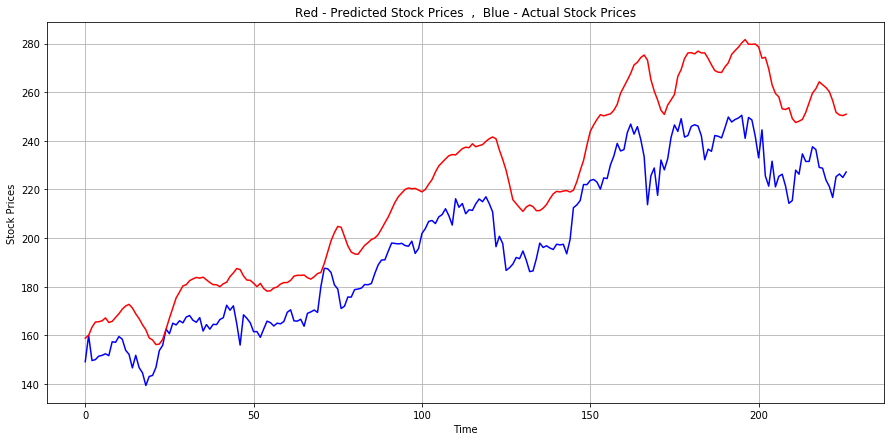

In [13]:
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
print('\n Actual Stock Prices')
print( pred[:10] )

testY2 = testY.reshape(testY.shape[0] , 1)
testY2 = scaler.inverse_transform(testY2)
print('\n Predicted Stock Prices ')
print( testY2[:10] )

print('畫圖')
print("\nRed - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(testY2 , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices')
plt.grid(True)
plt.show()
